# **Classification - NPL Credit Scoring**

## **Import Packages**

**Packages yang dipakai untuk manipulasi dan analisis data secara general.**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

**Packages yang dipakai untuk modelling/machine learning secara spesifik.**

In [2]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV

# Untuk SMOTE dan undersampling 
# Pastikan sudah pip install karena tidak ada di default Anaconda!
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

**Packages untuk kegunaan lain-lain.**

In [3]:
import os
import warnings

## **Define Functions and Settings**

**Function-function yang akan sering dipakai di keseluruhan notebook** didefinisikan terlebih dahulu, sehingga lebih mudah dikenali dan dipahami ketika digunakan dalam notebook ini.

In [4]:
def display_df(df, n = 5):
    '''
        Display the first n rows (default = 5) of a DataFrame and its shape
        Goal: To print short previews of a dataset and know its dimensions at the same time
    '''
    if n == 'all':
        display(df)
    elif type(n) == int:
        display(df.head(n))
    display(df.shape)

def batch_cross_val(model, X, y, kfold):
    '''
        Cross-validate a machine learning model and return all the four common metrics.
        Requires cross_validate to be imported!
    '''

    scoring_metrics = {
        'acc': 'accuracy',
        'prec': 'precision',
        'rec': 'recall',
        'F1': 'f1'
    }

    scores = cross_validate(model, X, y, cv = kfold, scoring = scoring_metrics)

    acc = scores['test_acc']
    print('Mean accuracy: {:.3f}'.format(acc.mean()))

    prec = scores['test_prec']
    print('Mean precision: {:.3f}'.format(prec.mean()))

    rec = scores['test_rec']
    print('Mean recall: {:.3f}'.format(rec.mean()))

    f1 = scores['test_F1']
    print('Mean F1-score: {:.3f}'.format(f1.mean()))
    
    return (acc, prec, rec, f1)

Beberapa **pengaturan dari packages yang berdampak dalam keseluruhan notebook** akan diatur dan dicatat terlebih dahulu disini.

In [5]:
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid')

## **Read Dataset**

**Menuliskan path folder tempat data disimpan terlebih dahulu.**

In [6]:
data_folder = 'data'

### **Data Train**

**Data train adalah data yang akan digunakan untuk melatih model machine learning.**

Data train terdiri dari 15,343 baris dan 24 kolom, serta dilengkapi dengan variabel target yang akan digunakan nanti, yaitu `flag_kredit_macet`. Terdapat kolom misterius, yaitu kolom `X`, yang akan diinvestigasi lebih lanjut setelah ini.

In [7]:
train_df = pd.read_csv(os.path.join(data_folder, 'npl_credit_scoring_train.csv'))

display_df(train_df)

,X,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,kode_cabang,rasio_pembayaran,...,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
0,92,5,5972272,6000000.0,5068230.0,0.0,0.0,5206434.0,NaN,12.19,...,0,9.916667,0.0,1041286.8,0.867739,0.000000,0.059401,0.041536,0.919164,0.919635
1,316,2,136453,65000000.0,128750.0,0.0,0.0,0.0,NaN,100.00,...,0,3.500000,0.0,0.0,0.000000,0.000000,0.023722,0.013271,0.022847,0.007724
2,624,1,1354080,3000000.0,1369203.0,0.0,15000.0,0.0,NaN,100.00,...,0,8.500000,15000.0,0.0,0.000000,0.005000,0.145833,0.000000,0.627426,0.899309
3,628,2,1076660,49000000.0,752108.0,0.0,775440.0,0.0,NaN,99.07,...,0,4.333333,775440.0,0.0,0.000000,0.015825,0.017617,0.177094,0.013699,0.255363
4,947,3,42281368,34000000.0,43130581.0,0.0,0.0,41144841.0,NaN,0.00,...,1,7.000000,0.0,13714947.0,1.210142,0.000000,0.412361,0.014556,1.205087,1.116092


(15343, 24)

**Berikut ini beberapa overview singkat dari data train.**

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15343 entries, 0 to 15342
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   X                                    15343 non-null  int64  
 1   jumlah_kartu                         15343 non-null  int64  
 2   outstanding                          15343 non-null  int64  
 3   limit_kredit                         15343 non-null  float64
 4   tagihan                              15343 non-null  float64
 5   total_pemakaian_tunai                15343 non-null  float64
 6   total_pemakaian_retail               15343 non-null  float64
 7   sisa_tagihan_tidak_terbayar          15343 non-null  float64
 8   kode_cabang                          15243 non-null  object 
 9   rasio_pembayaran                     15343 non-null  float64
 10  persentasi_overlimit                 15343 non-null  float64
 11  rasio_pembayaran_3bulan     

In [9]:
train_df.describe()

,X,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,...,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
count,15343.000000,15343.000000,1.534300e+04,1.534300e+04,1.534300e+04,1.534300e+04,1.534300e+04,1.534300e+04,15343.000000,15343.000000,...,15343.000000,15343.000000,1.534300e+04,1.534300e+04,15343.000000,15343.000000,15343.000000,15343.000000,15343.000000,15343.000000
mean,7750.138956,2.507332,1.160634e+07,2.081037e+07,8.087595e+06,7.468477e+04,2.032315e+06,8.138304e+06,64.482234,3.347169,...,0.087597,6.636067,2.107030e+06,2.964641e+06,0.468332,0.109579,0.167506,0.202896,0.571362,0.534084
std,4472.966163,1.014525,2.415412e+07,2.960443e+07,1.766835e+07,6.205923e+05,7.959575e+06,1.925786e+07,797.324307,9.257389,...,0.282717,4.682317,8.125462e+06,6.262742e+06,0.473221,0.200651,0.192300,0.275018,0.412303,0.432826
min,1.000000,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,-1.566720e+07,0.000000e+00,-18138.000000,0.000000,...,0.000000,0.750000,-1.566720e+07,0.000000e+00,0.000000,-0.632000,-0.126000,-0.569000,0.000288,0.000000
25%,3875.500000,2.000000,1.997592e+06,5.000000e+06,8.150830e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,2.920000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.035000,0.032900,0.189000,0.155000
50%,7752.000000,2.000000,4.724856e+06,9.000000e+06,3.141692e+06,0.000000e+00,2.010420e+05,2.750772e+06,26.900000,0.000000,...,0.000000,5.666667,2.480000e+05,1.209318e+06,0.335929,0.022100,0.108000,0.117000,0.576000,0.496000
75%,11624.500000,3.000000,1.061836e+07,2.200000e+07,7.420343e+06,0.000000e+00,1.403758e+06,7.139904e+06,100.000000,1.070000,...,0.000000,9.330000,1.513168e+06,3.083416e+06,0.930000,0.128000,0.239424,0.285000,0.917000,0.864000
max,15493.000000,16.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.884057e+07,2.850000e+08,4.440000e+08,68983.000000,190.000000,...,1.000000,34.416667,3.140000e+08,1.480000e+08,7.240000,4.600000,3.490000,8.110000,8.125671,9.730000


### **Data Test**

**Data test adalah data yang akan diprediksi dengan model yang sudah dilatih.**

Data test terdiri dari 150 baris dan 23 kolom, 1 kolom lebih sedikit dibandingkan data train karena ketiadaan variabel target `flag_kredit_macet`. Kolom misterius `X` juga ada di data test seperti pada data train, dan akan diinvestigasi lebih lanjut setelah ini.

In [10]:
test_df = pd.read_csv(os.path.join(data_folder, 'npl_credit_scoring_test.csv'))

display_df(test_df)

,X,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,kode_cabang,rasio_pembayaran,...,skor_delikuensi,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
0,6188,2,5025000,5000000.0,833333.0,900000.0,538002.0,3290742.0,F,100.0,...,0,6.75,1438002.0,1645371.0,0.658,0.288,0.0322,6.600000e-08,1.0200,1.2000
1,4783,2,509019,3000000.0,258000.0,0.0,418000.0,0.0,A,0.0,...,0,5.42,418000.0,0.0,0.000,0.139,0.0695,0.000000e+00,0.0897,0.0592
2,13414,2,5153766,5000000.0,5007495.0,0.0,5019950.0,5515204.0,F,0.0,...,0,7.67,5019950.0,2757602.0,1.100,1.000,0.4390,3.550000e-01,0.6740,0.3630
3,11819,3,29214412,35000000.0,28509908.0,0.0,4148000.0,29214022.0,A,0.0,...,0,13.70,4148000.0,9738007.0,0.835,0.119,0.0833,3.620000e-02,0.7920,0.7430
4,7416,2,40929,3000000.0,40100.0,0.0,0.0,0.0,B,0.0,...,0,6.42,0.0,0.0,0.000,0.000,0.0000,0.000000e+00,0.0107,0.0000


(150, 23)

**Berikut ini beberapa overview singkat dari data test.**

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   X                                    150 non-null    int64  
 1   jumlah_kartu                         150 non-null    int64  
 2   outstanding                          150 non-null    int64  
 3   limit_kredit                         150 non-null    float64
 4   tagihan                              150 non-null    float64
 5   total_pemakaian_tunai                150 non-null    float64
 6   total_pemakaian_retail               150 non-null    float64
 7   sisa_tagihan_tidak_terbayar          150 non-null    float64
 8   kode_cabang                          150 non-null    object 
 9   rasio_pembayaran                     150 non-null    float64
 10  persentasi_overlimit                 150 non-null    float64
 11  rasio_pembayaran_3bulan         

In [12]:
test_df.describe()

,X,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,...,skor_delikuensi,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
count,150.000000,150.000000,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,150.000000,150.000000,...,150.000000,150.000000,1.500000e+02,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,7425.926667,2.426667,1.077944e+07,1.956667e+07,7.164982e+06,5.900000e+04,1.365373e+06,8.403871e+06,81.512800,2.971667,...,0.006667,6.432200,1.424373e+06,3.317756e+06,0.459443,0.087215,0.161383,0.173214,0.544561,0.496405
std,4436.819080,0.797199,1.560297e+07,2.380272e+07,1.048165e+07,3.268761e+05,3.262666e+06,1.546054e+07,343.005366,7.508772,...,0.081650,3.918161,3.257153e+06,6.216436e+06,0.457270,0.139763,0.195670,0.183953,0.371804,0.380026
min,180.000000,2.000000,2.312000e+04,3.000000e+06,2.300000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.750000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.001290,0.000000
25%,3708.250000,2.000000,2.257512e+06,5.000000e+06,1.138527e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,3.330000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.044226,0.032300,0.197961,0.169000
50%,7384.000000,2.000000,5.038225e+06,9.000000e+06,3.462150e+06,0.000000e+00,1.758790e+05,2.899340e+06,40.450000,0.000000,...,0.000000,5.500000,2.474190e+05,1.209952e+06,0.291500,0.024900,0.103150,0.109000,0.504500,0.428000
75%,11177.500000,3.000000,1.267008e+07,2.000000e+07,7.161343e+06,0.000000e+00,1.080250e+06,8.133821e+06,100.000000,0.000000,...,0.000000,8.957500,1.416973e+06,3.595408e+06,0.914887,0.121250,0.212014,0.281750,0.916274,0.834750
max,15347.000000,6.000000,9.859690e+07,1.200000e+08,6.276755e+07,3.000000e+06,2.143566e+07,9.213385e+07,4198.850000,52.600000,...,1.000000,19.100000,2.143566e+07,4.606692e+07,1.410000,1.000000,1.700000,0.955000,1.280000,1.440000


### **Mengenai Kolom `X`**

**Kolom `X` diduga adalah kolom index yang tersisa setelah split data train dan test.**

Kecurigaan ini didasarkan karena kolom `X` pada data train, jika diurutkan, cukup runtut dari angka 1 hingg 15,493. Angka akhir 15,493 sendiri diduga berasal dari 15,343 baris panjang data train + 150 baris panjang data test.

In [13]:
train_df['X'].sort_values()

3896         1
8879         2
2375         3
9051         4
13545        5
         ...  
6627     15489
2797     15490
13932    15491
9787     15492
6909     15493
Name: X, Length: 15343, dtype: int64

**Berdasarkan hasil pengecekan, dugaan tersebut tepat.**

Apabila kolom `X` di kedua data digabung dan diurutkan, kemudian dibandingkan dengan angka berurutan dari angka 1 hingga 15,493 menggunakan np.arange(), maka ditemukan bahwa setiap nilai dalam kolom `X` cocok dengan teori sebelumnya.

In [14]:
combined_X = pd.concat([train_df['X'], test_df['X']])

print('Apakah kolom X sebenarnya hanyalah kolom index biasa?')
print(np.all(combined_X.sort_values() == np.arange(1, len(train_df) + len(test_df) + 1)))

Apakah kolom X sebenarnya hanyalah kolom index biasa?
True


**Kolom `X` akan dikeluarkan dari data train dan test.**

Karena sudah ada index yang urut dari data train dan test yang diciptakan oleh `pandas` saat data dibaca masuk, sementara data train dan test diperkirakan tidak akan berinteraksi lagi di masa depan yang membutuhkan kolom `X`, maka kolom `X` akan dihapus dari kedua data agar tidak ada index yang redundan.

In [15]:
train_df.drop('X', axis = 1, inplace = True)
test_df.drop('X', axis = 1, inplace = True)

print('Kolom X telah berhasil dihapus dari data train dan test!')

Kolom X telah berhasil dihapus dari data train dan test!


## **Problem Statement**

<u>**Berikut ini adalah masalah yang menjadi background case study kali ini:**</u>

- Data yang kita miliki sekarang adalah data dari Bank A, dimana sebagian besar kolomnya nampaknya berputar sekitar data penggunaan kartu kredit nasabah Bank A.
<br /><br />
- Dengan data yang telah kita baca di atas, <u>**Bank A ingin agar kita menciptakan sistem penilaian kelayakan kredit secara otomatis**</u> yang bisa memberikan rekomendasi menerima atau menolak pengajuan kredit nasabah, di mana rekomendasi ini dibuat melalui **prediksi kita tentang potensi kredit macet** dari nasabah tersebut. 
<br /><br />
- Selain itu, karena ini adalah kasus _credit scoring_, maka jika kita salah <u>**memprediksi seharusnya macet menjadi tidak macet**</u>, maka itu akan **menyebabkan kerugian yang besar pada Bank A** sehingga hal itu hendaknya dihindari.

<u>**Jika diterjemahkan dalam teknik machine learning, berarti:**</u>
- Kita memiliki _**classification problem**_, di mana
- **Variabel target kita adalah `flag_kredit_macet`** seperti ditemukan di pembacaan data sebelumnya, serta
- Goal kita adalah **memprediksi dengan meminimalisasi _false negative_** juga, di mana aspek tersebut dapat dinilai melalui **metrik _recall_**.

**Ada beberapa pertanyaan yang dapat kita cari jawabannya sambil kita menciptakan model:**
- Faktor-faktor apa saja yang dapat memprediksi nasabah yang akan kredit macet?
- Apakah ada pola yang dapat membantu kita untuk mengantisipasi nasabah akan kredit macet?


## **Exploratory Data Analysis**

**Sebelum memulai EDA, `plot_df` diciptakan untuk hasil plot yang lebih bersih.**

Karena secara default, nama kolom akan dijadikan label axis, maka diciptakan `plot_df` yang memiliki nama kolom yang lebih rapi untuk plot. Selain itu, nilai dari variabel target `flag_kredit_macet` juga diganti menjadi "Ya" dan "Tidak" dan diset sebagai tipe data `category` untuk tujuan plot yang lebih mudah diinterpretasi pula.

In [16]:
plot_df = train_df.copy()

plot_df.columns = plot_df.columns.\
    str.replace('_', ' ').str.title().\
    str.replace('(\d)(Bln|Bulan)', '\\1 Bulan', regex = True)

plot_df.rename(columns = {'Persentasi Overlimit': 'Persentase Overlimit'}, 
               inplace = True)

plot_df['Flag Kredit Macet'] = pd.Categorical(plot_df['Flag Kredit Macet'].\
    replace({0: 'Tidak', 1: 'Ya'}), categories = ['Ya', 'Tidak'])

display_df(plot_df)

,Jumlah Kartu,Outstanding,Limit Kredit,Tagihan,Total Pemakaian Tunai,Total Pemakaian Retail,Sisa Tagihan Tidak Terbayar,Kode Cabang,Rasio Pembayaran,Persentase Overlimit,...,Flag Kredit Macet,Jumlah Tahun Sejak Pembukaan Kredit,Total Pemakaian,Sisa Tagihan Per Jumlah Kartu,Sisa Tagihan Per Limit,Total Pemakaian Per Limit,Pemakaian 3 Bulan Per Limit,Pemakaian 6 Bulan Per Limit,Utilisasi 3 Bulan,Utilisasi 6 Bulan
0,5,5972272,6000000.0,5068230.0,0.0,0.0,5206434.0,NaN,12.19,0.00,...,Tidak,9.916667,0.0,1041286.8,0.867739,0.000000,0.059401,0.041536,0.919164,0.919635
1,2,136453,65000000.0,128750.0,0.0,0.0,0.0,NaN,100.00,0.00,...,Tidak,3.500000,0.0,0.0,0.000000,0.000000,0.023722,0.013271,0.022847,0.007724
2,1,1354080,3000000.0,1369203.0,0.0,15000.0,0.0,NaN,100.00,0.00,...,Tidak,8.500000,15000.0,0.0,0.000000,0.005000,0.145833,0.000000,0.627426,0.899309
3,2,1076660,49000000.0,752108.0,0.0,775440.0,0.0,NaN,99.07,0.00,...,Tidak,4.333333,775440.0,0.0,0.000000,0.015825,0.017617,0.177094,0.013699,0.255363
4,3,42281368,34000000.0,43130581.0,0.0,0.0,41144841.0,NaN,0.00,22.63,...,Ya,7.000000,0.0,13714947.0,1.210142,0.000000,0.412361,0.014556,1.205087,1.116092


(15343, 23)

<u>**NOTE PENTING: Mengapa banyak digunakan bar plot vs box plot di bawah ini?**</u>

Setelah mencocokkan antara angka rawnya (menggunakan `df.describe()`) dengan hasil bar plot dan box plot, ada cukup banyak angka dalam `train_df` yang masuk di atas right/top whisker dari box plot dan bertumpuk-tumpuk. 

Kelemahan dari box plot sebenarnya adalah ketika data pointnya sudah masuk "outlier", tidak terlihat sebenarnya ada berapa banyak outlier tersebut. Ini bisa diatasi oleh swarm plot atau sejenisnya, tetapi swarm plot dengan ribuan data sangat lama loadingnya. Oleh karena itu, untuk mengakalinya akan digunakan lebih banyak bar plot di bawah ini. Namun, apabila kolom yang sedang dianalisis lebih cocok dengan box plot, maka box plot akan digunakan di bawah ini.

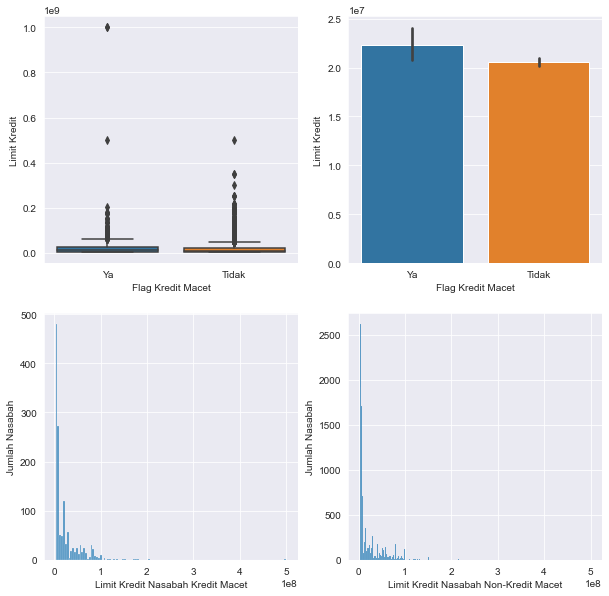

In [17]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

sns.boxplot(x = 'Flag Kredit Macet', y = 'Limit Kredit', 
            ax = axes[0, 0],
            data = plot_df)

sns.barplot(x = 'Flag Kredit Macet', y = 'Limit Kredit', 
            ax = axes[0, 1], # line selanjutnya akan menghilangkan dampak outlier terbesar
            data = plot_df[plot_df['Limit Kredit'] <= (0.8 * 10 ** 9)])

sns.histplot(x = 'Limit Kredit',
             data = plot_df[(plot_df['Flag Kredit Macet'] == 'Ya') & (plot_df['Limit Kredit'] <= (0.8 * 10 ** 9))], 
             ax = axes[1, 0]).\
    set(xlabel = 'Limit Kredit Nasabah Kredit Macet', ylabel = 'Jumlah Nasabah')

sns.histplot(x = 'Limit Kredit', 
             data = plot_df[plot_df['Flag Kredit Macet'] == 'Tidak'], 
             ax = axes[1, 1]).\
    set(xlabel = 'Limit Kredit Nasabah Non-Kredit Macet', ylabel = 'Jumlah Nasabah')

plt.show()

Berikut ini contohnya, dimana secara box plot nampaknya nasabah kredit macet memiliki limit kredit lebih rendah, padahal sebenarnya jika dihitung rata-ratanya ternyata relatif lebih tinggi (bahkan setelah mengkompensasi outlier terekstrem nasabah kredit macet!).

**Mungkin ada teknik lain untuk mengakalinya atau penjelasan yang tidak penulis ketahui**, namun untuk sekarang bar plot nampaknya trade-off yang cukup baik, terutama dalam presentasi yang langsung ke _takeaway_.

### **Flag Kredit Macet**

**Berapa proporsi nasabah yang mengalami kredit macet dalam data?**

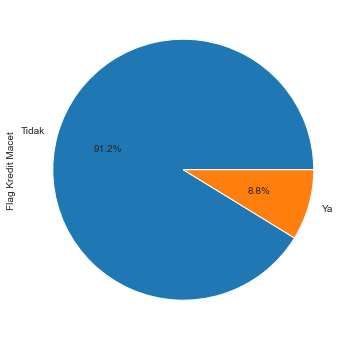

In [18]:
plt.figure(figsize = (6, 6))
plot_df['Flag Kredit Macet'].value_counts().plot.pie(autopct = '%1.1f%%')

plt.show()

**Data ini memiliki imbalanced class dalam variabel targetnya.**

Ada jauh lebih banyak nasabah dengan kredit tidak macet dibandingkan nasabah kredit macet. Kemungkinan besar, ini akan perlu ditangani nanti.

### **Kemampuan Membayar**

**Apakah kredit macet berhubungan dengan sisa tagihan tidak terbayar?**

Definisi _non-performing loans_ atau kredit macet umumnya memerlukan kredit yang sudah 3-6 bulan yang tidak dibayar oleh nasabah, sehingga keberadaan tagihan tidak terbayar dapat menjadi tanda awal yang baik dari kemungkinan kredit macet.

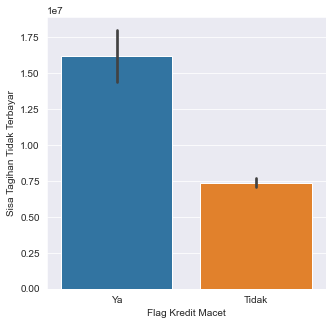

In [19]:
plt.figure(figsize = (5, 5))

sns.barplot(x = 'Flag Kredit Macet', y = 'Sisa Tagihan Tidak Terbayar', 
            data = plot_df)

plt.show()

<u>**Nasabah dengan kredit macet memiliki sisa tagihan tidak terbayar yang lebih tinggi!**</u>

**Apakah rasio pembayaran nasabah dengan kredit macet juga lebih rendah?**

Kesulitan untuk membayar keseluruhan tagihan juga merupakan pertanda nasabah akan kredit macet yang bagus.

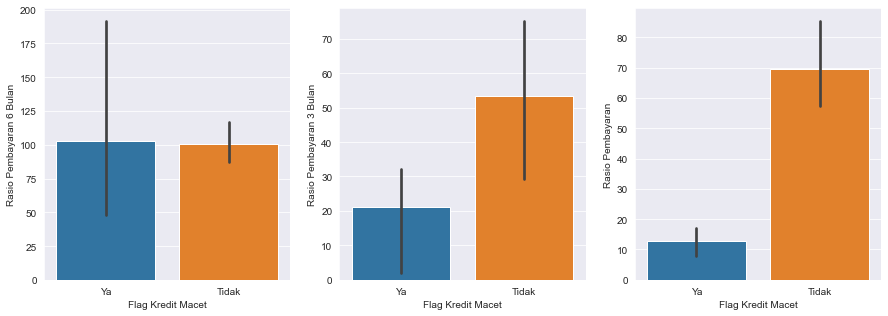

In [20]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

sns.barplot(x = 'Flag Kredit Macet', y = 'Rasio Pembayaran 6 Bulan', 
            data = plot_df[plot_df['Rasio Pembayaran 6 Bulan'] >= 0], ax = axes[0])

sns.barplot(x = 'Flag Kredit Macet', y = 'Rasio Pembayaran 3 Bulan', 
            data = plot_df, ax = axes[1])

sns.barplot(x = 'Flag Kredit Macet', y = 'Rasio Pembayaran', 
            data = plot_df, ax = axes[2])

plt.show()

<u>**Secara garis besar, nasabah kredit macet memang memiliki rasio pembayaran yang lebih rendah!**</u>

Serta, nampaknya ada nilai minus yang janggal pada rasio pembayaran 6 bulan...

**Apakah mungkin sisa tagihan tidak terbayar nasabah kredit macet dipengaruhi limit kartu?**

Misalnya, bisa jadi sisa tagihan tidak terbayar tinggi juga karena limit kartu nasabah kredit macet cenderung tinggi.

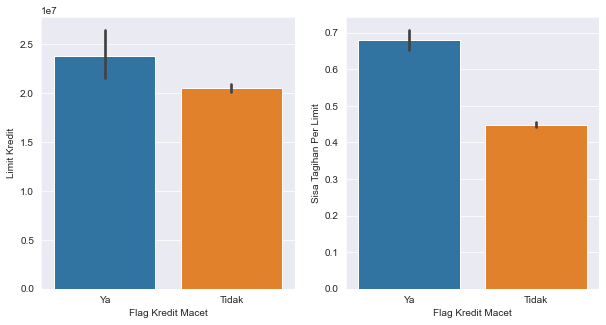

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.barplot(x = 'Flag Kredit Macet', y = 'Limit Kredit', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Sisa Tagihan Per Limit', 
            data = plot_df, ax = axes[1])

plt.show()

Ternyata memang benar <u>**nasabah dengan kredit macet memiliki kecenderungan limit yang relatif lebih tinggi**</u>, namun secara <u>**sisa tagihan tidak terbayar tetap tergolong tinggi**</u> meskipun memperhitungkan limit yang lebih tinggi.

**Apakah mungkin sisa tagihan tidak terbayar nasabah kredit macet juga dipengaruhi jumlah kartu yang dimiliki?**

Alternatif lain yang menarik diperiksa selain limit kartu sebelumnya, dengan alasan yang kurang lebih sama dengan sebelumnya.

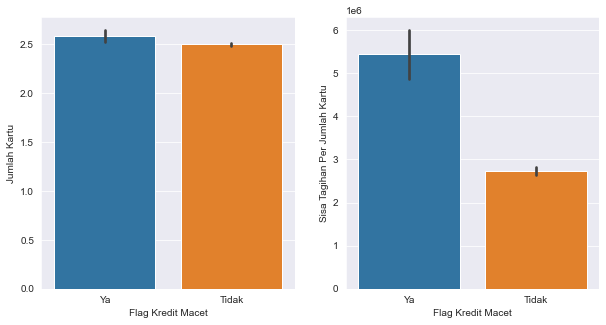

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.barplot(x = 'Flag Kredit Macet', y = 'Jumlah Kartu', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Sisa Tagihan Per Jumlah Kartu', 
            data = plot_df, ax = axes[1])

plt.show()

<u>**Sepertinya jumlah kartu nasabah dengan kredit macet relatif sama dengan nasabah dengan kredit non-macet.**</u>

Oleh karena itu, sisa tagihan jika dihitung per jumlah kartu juga tidak memiliki perbedaan substansial.

**Apakah nasabah kredit macet cenderung memiliki nilai outstanding dan/atau tagihan tinggi juga?**

Terlalu banyak tagihan atau outstanding di kartu kredit juga salah satu resep yang baik untuk menghasilkan ketidakmampuan membayar.

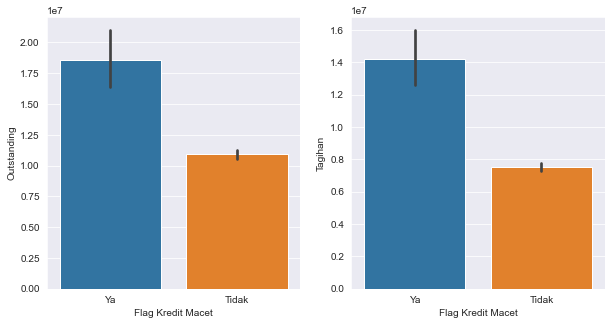

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.barplot(x = 'Flag Kredit Macet', y = 'Outstanding', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Tagihan', 
            data = plot_df, ax = axes[1])

plt.show()

<u>**Nampaknya sungguh-sungguh ada perbedaan substansial antara tagihan dan/atau outstanding nasabah kredit macet dan non-kredit macet!**</u>

**Apakah mungkin tagihan dan/atau outstanding nasabah kredit macet dapat dijelaskan dengan limit kredit yang lebih tinggi?**

Mungkinkah tagihan dan/atau outstanding yang lebih tinggi ini bisa dijelaskan oleh limit kartu yang lebih tinggi sebelumnya? Untuk mengetahuinya, kita akan mencoba grafik lain untuk sekarang, yakni scatter plot.

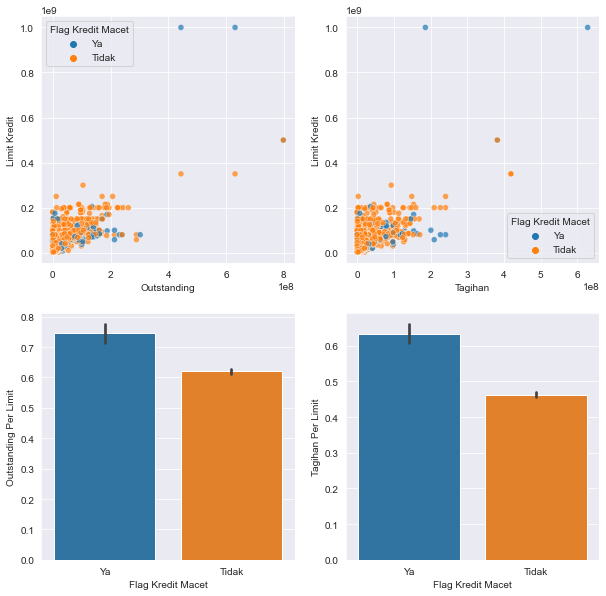

In [24]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

sns.scatterplot(x = 'Outstanding', y = 'Limit Kredit', hue = 'Flag Kredit Macet',
                data = plot_df, ax = axes[0, 0], alpha = 0.7)
sns.scatterplot(x = 'Tagihan', y = 'Limit Kredit', hue = 'Flag Kredit Macet',
                data = plot_df, ax = axes[0, 1], alpha = 0.7)

plot_df['Outstanding Per Limit'] = plot_df['Outstanding'] / plot_df['Limit Kredit']
plot_df['Tagihan Per Limit'] = plot_df['Tagihan'] / plot_df['Limit Kredit']

sns.barplot(x = 'Flag Kredit Macet', y = 'Outstanding Per Limit', 
            data = plot_df, ax = axes[1, 0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Tagihan Per Limit', 
            data = plot_df, ax = axes[1, 1])

plt.show()

<u>**Limit yang lebih tinggi cukup menjelaskan outstanding dan/atau tagihan nasabah kredit macet yang lebih tinggi, meskipun tidak sepenuhnya.**</u>

### **Perilaku Penggunaan Kartu Kredit**

<u>**Sebenarnya, dari mana awalnya para nasabah kredit macet ini bisa memiliki outstanding/tagihan yang lebih tinggi?**</u>

**Apakah nasabah kredit macet memiliki total pemakaian yang lebih tinggi, sejak awal?**

Jika total pemakaian lebih tinggi, tentu akan lebih mudah menghasilkan tagihan yang lebih tinggi pula. Selain itu, kita akan langsung bandingkan dengan limit kredit juga.

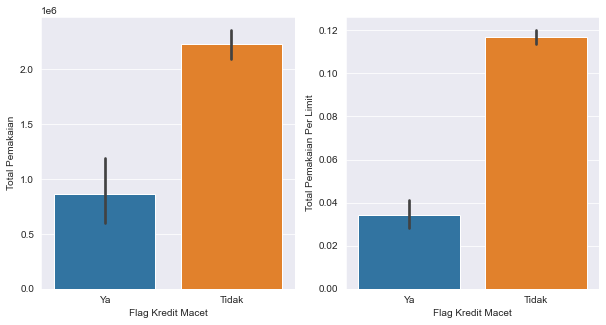

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.barplot(x = 'Flag Kredit Macet', y = 'Total Pemakaian', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Total Pemakaian Per Limit', 
            data = plot_df, ax = axes[1])

plt.show()

<u>**Menariknya, justru total pemakaian nasabah kredit macet jauh lebih rendah dibandingkan dengan nasabah non-kredit macet!**</u>

Tidak hanya itu, efek ini tetap sama atau justru lebih kuat setelah dibandingkan dengan limit kreditnya. Mungkin karena tagihan yang sudah ada sudah cukup berat, jadi mereka tidak menambah pemakaian lagi? Atau karena sudah terlalu dekat limit sehingga tidak bisa pemakaian banyak juga?

**Bagaimana rata-rata pemakaian nasabah kredit macet selama 3 dan 6 bulan ke belakang?**

Bisa jadi bulan-bulan sebelumnya pemakaiannya masih bisa lebih besar, benar kan? Kali ini, kita akan membandingkan langsung dengan limit kredit.

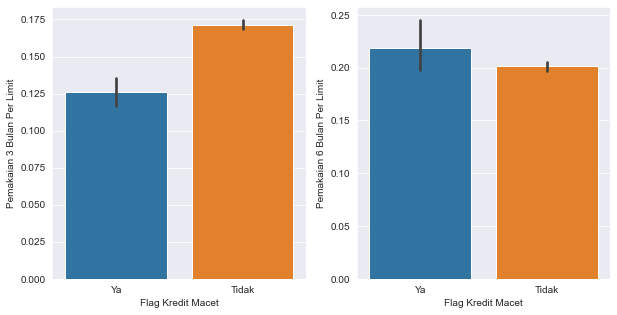

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.barplot(x = 'Flag Kredit Macet', y = 'Pemakaian 3 Bulan Per Limit', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Pemakaian 6 Bulan Per Limit', 
            data = plot_df, ax = axes[1])

plt.show()

<u>**Nasabah kredit macet nampaknya menggunakan kartu kredit cukup banyak 6 bulan yang lalu, lalu menurun hingga saat ini!**</u>

Pemakaian nampaknya turun sejak 6 bulan hingga di titik saat ini di mana level pemakaiannya menjadi sangat rendah. Implikasinya, banyak dari beban yang ditanggung nasabah kredit macet saat ini berasal dari pemakaian paling tidak sekitar 6 bulan yang lalu.

**Bagaimana rata-rata utilisasi kartu kredit dari nasabah kredit macet kini, 3, dan 6 bulan ke belakang?**

Pemakaian akan menunjukkan penggunaan pada bulan tersebut, tetapi utilisasi juga akan menunjukkan penumpukan dari bulan-bulan sebelumnya.

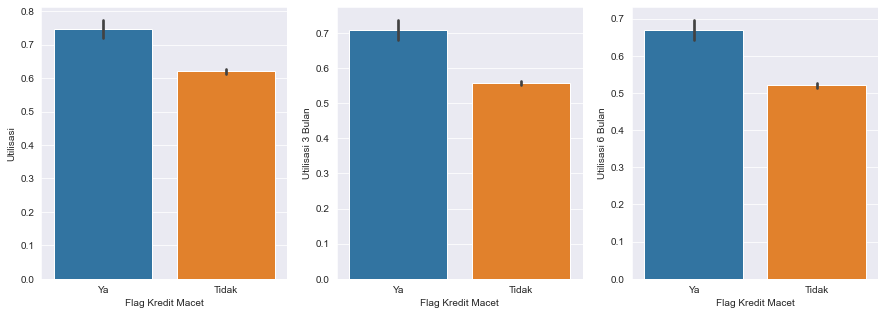

In [27]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

plot_df['Utilisasi'] = plot_df['Outstanding'] / plot_df['Limit Kredit']

sns.barplot(x = 'Flag Kredit Macet', y = 'Utilisasi', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Utilisasi 3 Bulan', 
            data = plot_df, ax = axes[1])
sns.barplot(x = 'Flag Kredit Macet', y = 'Utilisasi 6 Bulan', 
            data = plot_df, ax = axes[2])

plt.show()

<u>**Secara relatif, utilisasi tidak ada perubahan mencolok, tetapi baik nasabah kredit macet maupun yang non-kredit macet terus menerus naik utilisasinya...**</u>

Misalnya, nasabah non-kredit macet bermula dari sekitar 50% di utilisasi 6 bulan, lalu ~56% di utilisasi 3 bulan, dan kini ~62% di utilisasi bulan ini. Menarik, meskipun sayangnya kolom datanya agak kurang untuk dikejar alasannya kenapa...

**Apakah nasabah kredit macet sering menggunakan kartu hingga overlimit?**

Overlimit kartu dapat menandakan kebutuhan menggunakan kredit yang mendesak hingga harus menggunakan overlimit, serta juga dikenakan biaya overlimit, sehingga overlimit merupakan salah satu elemen yang dapat memberatkan tagihan dan/atau outstanding nasabah pula.

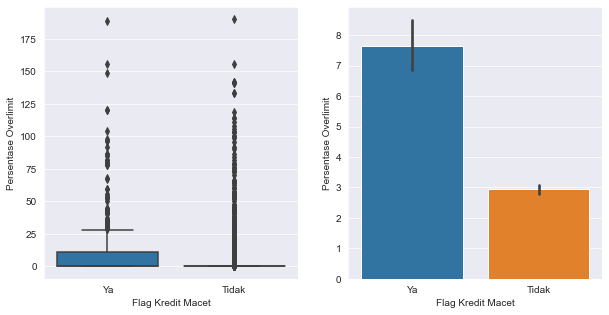

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.boxplot(x = 'Flag Kredit Macet', y = 'Persentase Overlimit', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Persentase Overlimit', 
            data = plot_df, ax = axes[1])

plt.show()

<u>**Nasabah kredit macet memiliki tendensi lebih tinggi untuk memiliki overlimit!**</u>

Baik nasabah kredit macet maupun kredit non-macet bisa memiliki overlimit, namun nasabah kredit macet memiliki kecenderungan lebih tinggi untuk overlimit. Kecenderungan apa lagi yang umumnya dimiliki oleh nasabah kredit macet?

### **Sifat Nasabah Kredit Macet Lainnya**

<u>**Pola-pola apa lagi yang dimiliki oleh nasabah kredit macet umumnya?**</u>

**Apakah nasabah kredit macet memiliki preferensi untuk salah satu jenis pemakaian kredit?**

Misalnya, apakah nasabah kredit macet memiliki kecenderungan lebih untuk menggunakan pemakaian tunai? Pemakaian tunai umumnya memiliki fee tambahan, sehingga itu juga dapat memperberat tagihan sebenarnya.

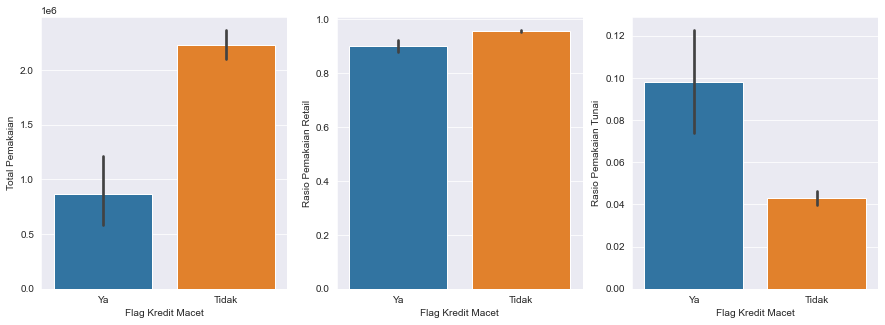

In [29]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

plot_df['Rasio Pemakaian Retail'] = plot_df['Total Pemakaian Retail'] / plot_df['Total Pemakaian']
plot_df['Rasio Pemakaian Tunai'] = plot_df['Total Pemakaian Tunai'] / plot_df['Total Pemakaian']

sns.barplot(x = 'Flag Kredit Macet', y = 'Total Pemakaian', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Rasio Pemakaian Retail', 
            data = plot_df, ax = axes[1])
sns.barplot(x = 'Flag Kredit Macet', y = 'Rasio Pemakaian Tunai', 
            data = plot_df, ax = axes[2])

plt.show()

<u>**Nasabah kredit macet ditemukan memiliki kecenderungan lebih tinggi terhadap pemakaian tunai.**</u>

Penggunaan pemakaian retail justru sedikit lebih kecil dibandingkan nasabah kredit non-macet, meskipun kurang lebih cukup dekat (perlu diingat juga bahwa rasio pemakaian retail adalah kebalikan dari rasio pemakaian tunai).

**Apakah nasabah kredit macet cenderung memiliki nilai outstanding di atas nilai tagihan bulan tersebut?**

Jika ada nasabah dengan nilai outstanding di atas nilai tagihan, bisa juga disebabkan oleh hal-hal seperti mengambil cicilan, sehingga ada kreditnya yang tidak langsung ditagihkan saat bulan tersebut. 

Jika iya, maka akan semakin berbahaya jika nasabah tidak dapat membayar tagihan saat bulan itu, karena tagihan bulan itu pun hanya sebagian dari total kredit nasabah tersebut sesungguhnya.

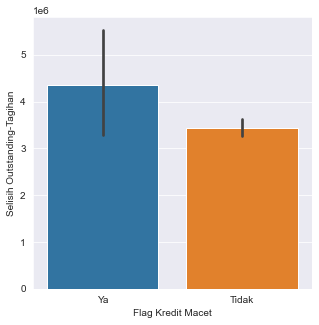

In [30]:
plt.figure(figsize = (5, 5))

plot_df['Selisih Outstanding-Tagihan'] = plot_df['Outstanding'] - plot_df['Tagihan']

sns.barplot(x = 'Flag Kredit Macet', y = 'Selisih Outstanding-Tagihan', 
            data = plot_df)

plt.show()

<u>**Karena batang confidence interval cukup panjang, sulit dikonklusikan apakah nasabah kredit macet lebih tinggi atau tidak.**</u>

**Apakah nasabah kredit macet memiliki skor delikuensi yang lebih tinggi?**

Karena nasabah memiliki kredit macet sekarang, bisa juga skor delikuensinya di masa lalu juga kurang baik.

Proporsi skor delikuensi:


,Skor Delikuensi,Proporsi (%)
0,0,99.73
1,1,0.18
2,2,0.03
3,4,0.03
4,5,0.02
5,3,0.01


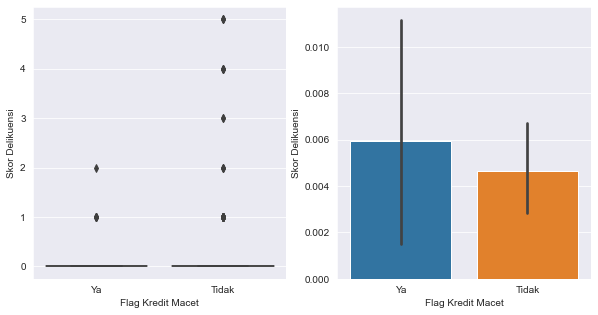

In [31]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

# Perlu menjadi tabel karena terlalu kecil untuk muncul di plot jika tidak
proporsi_skor_delikuensi = plot_df['Skor Delikuensi'].\
    value_counts(normalize = True).reset_index().\
        rename(columns = {'index': 'Skor Delikuensi', 
                          'Skor Delikuensi': 'Proporsi (%)'})
    
proporsi_skor_delikuensi['Proporsi (%)'] = (proporsi_skor_delikuensi['Proporsi (%)'] * 100).round(2)

print('Proporsi skor delikuensi:')
display(proporsi_skor_delikuensi)

sns.boxplot(x = 'Flag Kredit Macet', y = 'Skor Delikuensi', 
            data = plot_df, ax = axes[0])
sns.barplot(x = 'Flag Kredit Macet', y = 'Skor Delikuensi', 
            data = plot_df, ax = axes[1])

plt.show()

<u>**Inkonklusif, namun outlier terbesar skor delikuensi justru berasal dari nasabah non-kredit macet.**</u>

**Bagaimana pola panjang _tenure_ nasabah antara nasabah kredit macet dengan non-kredit macet?**

Nasabah kredit macet bisa jadi nasabah baru yang belum terbukti secara _track record_, meskipun bisa pula tidak seperti itu seperti dengan skor delikuensi.

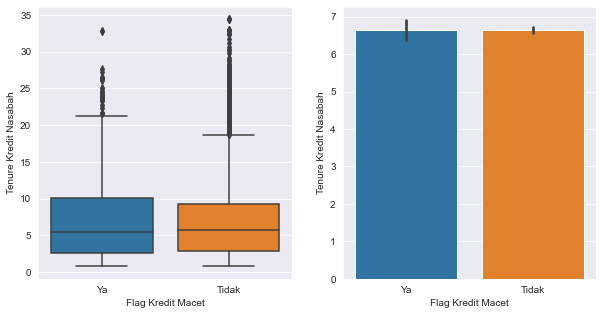

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.boxplot(x = 'Flag Kredit Macet', y = 'Jumlah Tahun Sejak Pembukaan Kredit', 
            data = plot_df, ax = axes[0]).set(ylabel = 'Tenure Kredit Nasabah')
sns.barplot(x = 'Flag Kredit Macet', y = 'Jumlah Tahun Sejak Pembukaan Kredit', 
            data = plot_df, ax = axes[1]).set(ylabel = 'Tenure Kredit Nasabah')

plt.show()

<u>**Inkonklusif juga berdasarkan panjang _whisker_, jumlah outlier, maupun barplot.**</u>

**Apakah nasabah kredit macet lebih banyak ditemukan di cabang tertentu?**

Jika dapat ditemukan seperti itu, tentunya itu adalah suatu pola yang menarik juga.

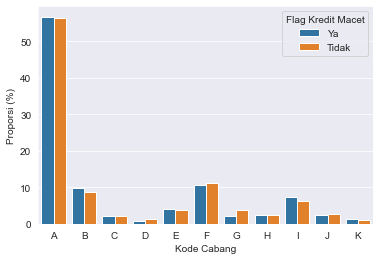

In [33]:
flag_per_cabang = plot_df.groupby(['Kode Cabang', 'Flag Kredit Macet']).size()
flag_cabang_df = pd.DataFrame({'Ya': flag_per_cabang[:, 'Ya'] / flag_per_cabang[:, 'Ya'].sum() * 100, 
                               'Tidak': flag_per_cabang[:, 'Tidak'] / flag_per_cabang[:, 'Tidak'].sum() * 100, 
                               'Kode Cabang': pd.Categorical(flag_per_cabang[:, 'Ya'].index)})

flag_cabang_df = flag_cabang_df.melt(id_vars = 'Kode Cabang', 
                                     var_name = 'Flag Kredit Macet', 
                                     value_name = 'Proporsi (%)')

sns.barplot(x = 'Kode Cabang', y = 'Proporsi (%)', 
            data = flag_cabang_df, hue = 'Flag Kredit Macet')

plt.show()

<u>**Tidak ada cabang khusus dimana ada sangat banyak nasabah kredit macet.**</u>

Implikasi lainnya, analisis tentang nasabah kredit macet bisa digeneralisir antar cabang juga!

## **Data Pre-processing**

**Sebagian besar akan berkutat pada data train, kecuali masalah yang sama juga ada di data test dan perlu ditangani.**

### **Missing Value**

**Di antara semua baris, hanya ada satu baris yang memiliki missing value dan akan kita tangani.**

In [34]:
train_df.isnull().sum()

jumlah_kartu                             0
outstanding                              0
limit_kredit                             0
tagihan                                  0
total_pemakaian_tunai                    0
total_pemakaian_retail                   0
sisa_tagihan_tidak_terbayar              0
kode_cabang                            100
rasio_pembayaran                         0
persentasi_overlimit                     0
rasio_pembayaran_3bulan                  0
rasio_pembayaran_6bulan                  0
skor_delikuensi                          0
flag_kredit_macet                        0
jumlah_tahun_sejak_pembukaan_kredit      0
total_pemakaian                          0
sisa_tagihan_per_jumlah_kartu            0
sisa_tagihan_per_limit                   0
total_pemakaian_per_limit                0
pemakaian_3bln_per_limit                 0
pemakaian_6bln_per_limit                 0
utilisasi_3bulan                         0
utilisasi_6bulan                         0
dtype: int6

**Missing value dari kolom `kode_cabang` diisi dengan modus.**

Modus dipilih karena sejauh EDA tadi, tidak ditemukan pola khusus antara kode cabang dengan variabel target kita, sehingga diisi dengan cara standar untuk variabel kategorikal saja.

In [35]:
train_df.loc[train_df['kode_cabang'].isnull(), 'kode_cabang'] = train_df['kode_cabang'].mode()[0]

train_df.isnull().sum()

jumlah_kartu                           0
outstanding                            0
limit_kredit                           0
tagihan                                0
total_pemakaian_tunai                  0
total_pemakaian_retail                 0
sisa_tagihan_tidak_terbayar            0
kode_cabang                            0
rasio_pembayaran                       0
persentasi_overlimit                   0
rasio_pembayaran_3bulan                0
rasio_pembayaran_6bulan                0
skor_delikuensi                        0
flag_kredit_macet                      0
jumlah_tahun_sejak_pembukaan_kredit    0
total_pemakaian                        0
sisa_tagihan_per_jumlah_kartu          0
sisa_tagihan_per_limit                 0
total_pemakaian_per_limit              0
pemakaian_3bln_per_limit               0
pemakaian_6bln_per_limit               0
utilisasi_3bulan                       0
utilisasi_6bulan                       0
dtype: int64

### **Data Duplikat**

**Berdasarkan pengecekan, tidak ada data duplikat dalam data train.**

Begitu pula pada data test, meskipun tidak dicantumkan disini.

In [36]:
train_df.duplicated().sum()

0

### **Data Outliers**

**Outliers pada data train tidak dapat langsung dihilangkan karena sangat umum ditemukan.**

Pada data train, nampaknya outliers adalah sesuatu yang lumrah dan biasa, dan outliers seringkali adalah nilai-nilai yang membedakan salah satu dari kelas variabel target, terutama jika perbedaan antar kelas cukup besar seperti yang disajikan pada bagian EDA. Oleh karena outliers memuat informasi penting, outliers tidak dapat dihapus begitu saja.

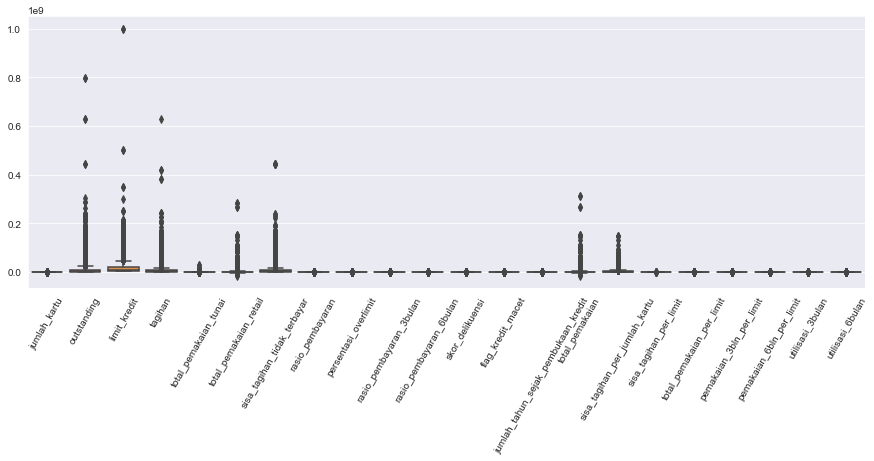

In [37]:
plt.figure(figsize = (15, 5))

sns.boxplot(data = train_df)
plt.xticks(rotation = 60)

plt.show()

**Akan tetapi, tetap ada beberapa nilai outlier yang terlalu jauh di luar batas normal sehingga dapat dibersihkan.**

Misalnya, nilai pada kolom `rasio_pembayaran` yang seharusnya 0-100% saja, namun ada nilai positif atau negatif hingga ribuan. Nilai-nilai ini bisa dihilangkan apabila tidak ada penjelasan yang bagus. Nilai-nilai ini terlalu di luar batas normal, dan nilai ini tidak banyak jumlahnya, sehingga perbedaan ini bukan fitur unik yang menjadi identitas salah satu kelas di variabel target kita. 

In [38]:
print(f'Jumlah baris data train sebelum pembersihan outlier: {len(train_df)}')

Jumlah baris data train sebelum pembersihan outlier: 15343


**Daftar kolom yang memiliki kejanggalan:**
<br /><br />

- `rasio_pembayaran`, `rasio_pembayaran_3bulan`, `rasio_pembayaran_6bulan`: seharusnya hanya sekitar 0-100%, atau setidaknya tidak sampai ribuan persen positif atau negatif, dan sejauh ini tidak ada penjelasan yang bagus.
<br /><br />

- `total_pemakaian_retail`, `total_pemakaian`, `total_pemakaian_per_limit`, `pemakaian_3bln_per_limit`, `pemakaian_6bln_per_limit`: keluarga ini total pemakaian ini memiliki nilai negatif sehingga cukup janggal, tetapi ada kemungkinan itu disebabkan oleh pembayaran kartu kredit dan sejauh ini konsisten (ketika satu negatif, semuanya negatif) sehingga untuk sekarang ditoleransi.
<br /><br />

- `persentasi_overlimit`, `utilisasi_3bulan`, dan `utilisasi_6bulan`: di luar kewajaran pula, namun masih ditoleransi karena masih mendekati batas masuk akal.
<br /><br />

**Oleh karena itu, kolom-kolom yang dirasa perlu koreksi adalah kolom-kolom rasio pembayaran.** 

In [39]:
outlier_detector_df = train_df.describe().loc[['min', '50%', 'max']]

display(outlier_detector_df.iloc[:, 0:12])
display(outlier_detector_df.iloc[:, 12:24])

,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,rasio_pembayaran_6bulan,skor_delikuensi
min,1.0,0.0,3.000000e+06,20043.0,0.0,-15667200.0,0.0,-18138.0,0.0,-57792.34,-77056.0,0.0
50%,2.0,4724856.0,9.000000e+06,3141692.0,0.0,201042.0,2750772.0,26.9,0.0,50.00,65.6,0.0
max,16.0,798058574.0,1.000000e+09,628000000.0,28840572.0,285000000.0,444000000.0,68983.0,190.0,75575.00,54899.0,5.0


,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
min,0.0,0.750000,-15667200.0,0.0,0.000000,-0.6320,-0.126,-0.569,0.000288,0.000
50%,0.0,5.666667,248000.0,1209318.0,0.335929,0.0221,0.108,0.117,0.576000,0.496
max,1.0,34.416667,314000000.0,148000000.0,7.240000,4.6000,3.490,8.110,8.125671,9.730


**Seperti yang dapat dilihat, outlier yang satu ini cukup sulit dicari justifikasinya.**

Berbeda dengan kolom-kolom total pemakaian, dimana ketika satu kolom negatif semuanya ikut negatif, tidak ada pola yang ditemukan disini, sehingga data outlier ini akan dihapus.

In [40]:
correction_columns = ['rasio_pembayaran', 'rasio_pembayaran_3bulan', 
                      'rasio_pembayaran_6bulan']

extreme_negative_filter = (train_df[correction_columns] < 0).any(axis = 1)

train_df.loc[extreme_negative_filter, ['tagihan'] + correction_columns]

,tagihan,rasio_pembayaran,rasio_pembayaran_3bulan,rasio_pembayaran_6bulan
30,78629.0,0.00,-48.0,33.30
413,1018492.0,244.00,355.0,-141.00
433,70992.0,0.00,0.0,-85.30
542,197464.0,182.91,123.2,-19.32
633,34394.0,0.00,-642.0,50.00
...,...,...,...,...
14682,506000.0,0.00,-216.0,65.70
14883,244025.0,-2100.00,-11068.0,-77056.00
14976,763707.0,0.00,-94.7,105.00
15054,2134749.0,-498.00,60.2,105.00


In [41]:
# Setara dengan membayar kembali tagihan kita 10 kali lipat
extreme_positive_filter = (train_df[correction_columns] > 1000).any(axis = 1)

train_df.loc[extreme_positive_filter, ['tagihan'] + correction_columns]

,tagihan,rasio_pembayaran,rasio_pembayaran_3bulan,rasio_pembayaran_6bulan
13,642313.0,0.00,0.0,1518.0
582,810294.0,107.00,100.0,7069.0
646,11942091.0,100.00,100.0,4444.0
650,574643.0,0.00,908.0,1013.0
768,7465907.0,981.00,863.0,3090.0
...,...,...,...,...
14894,628000000.0,0.00,75.0,54899.0
14930,1860712.0,3717.00,954.0,51.4
15125,5788609.0,33.80,38.6,8729.0
15154,638701.0,9556.00,2569.0,80.2


In [42]:
dropped_rows = train_df[extreme_negative_filter | extreme_positive_filter].index
train_df.drop(dropped_rows, inplace = True)

train_df[(train_df[correction_columns] < 0).any(axis = 1)]

,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,kode_cabang,rasio_pembayaran,persentasi_overlimit,...,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan


**Data train tidak berkurang banyak setelah pembersihan outlier.**

Hal itu merupakan pertanda bagus, sebab jika terlalu banyak outlier yang dihapus, kita akan mengurangi informasi terlalu banyak dari data kita atau sebenarnya itu bukan outlier yang seharusnya dihapus.

In [43]:
print(f'Jumlah baris data train setelah pembersihan outlier: {len(train_df)}')

Jumlah baris data train setelah pembersihan outlier: 15077


### **Transformasi Data Kategorikal**

**Kolom `kode_cabang` akan ditransformasikan dari kategorikal menjadi integer, baik di data train maupun test.**

Kolom ini adalah satu-satunya kolom non-numerik yang ada dalam data kita.

In [44]:
train_df.select_dtypes('object').columns

Index(['kode_cabang'], dtype='object')

**Transformasi menggunakan `LabelEncoder` berhasil dilakukan.**

In [45]:
label_encoder = LabelEncoder()

train_df['kode_cabang'] = label_encoder.fit_transform(train_df['kode_cabang'])
test_df['kode_cabang'] = label_encoder.fit_transform(test_df['kode_cabang'])

train_df['kode_cabang'].unique()

array([ 0,  2,  5,  1,  6,  8,  3,  7,  9, 10,  4])

## **Feature Engineering**

### **Feature Selection**

**Kita akan menggunakan korelasi sebagai alat dasar untuk memilih kolom yang akan digunakan.**

Korelasi pada umumnya tersebar dan cukup kecil, kecuali kolom yang bersangkutan merupakan satu rumpun kolom atau memang merupakan derivasi dari kolom yang berkorelasi tinggi tersebut (misalnya `outstanding` dan `tagihan`).  

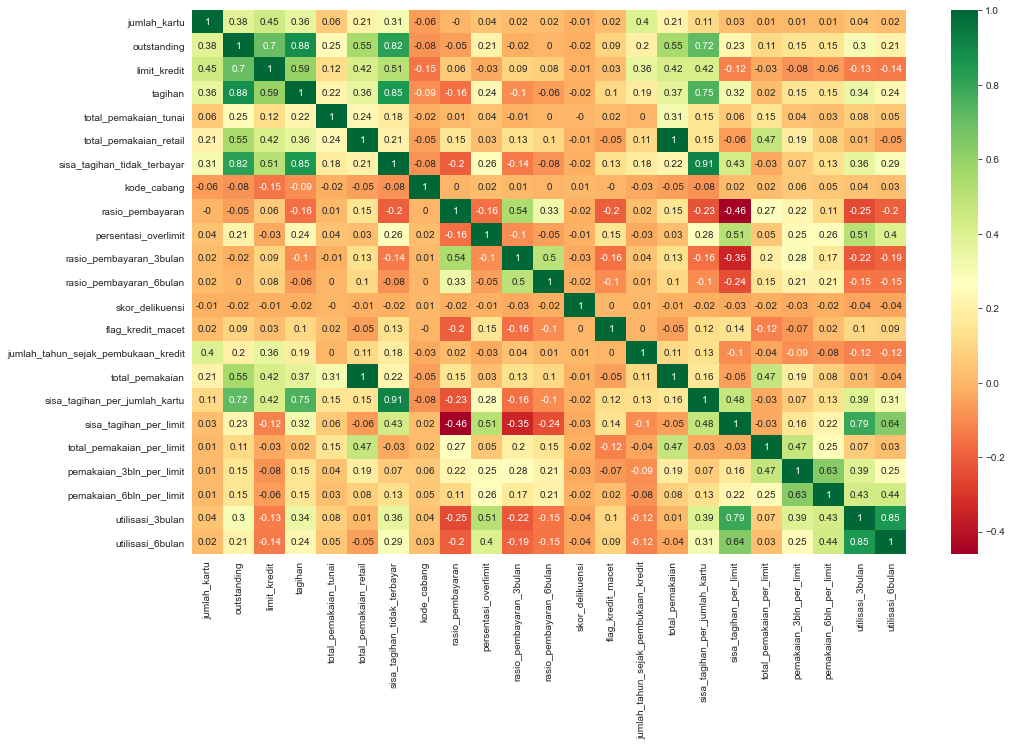

In [46]:
plt.figure(figsize = (16, 10))

sns.heatmap(train_df.corr().round(2), annot = True, cmap = 'RdYlGn')

plt.show()

**Daftar ini dapat digunakan untuk memotong variabel dengan korelasi rendah.**

Menariknya, tiga kolom terbawah adalah tiga kolom yang kita nyatakan inkonklusif di akhir EDA!

In [47]:
korelasi_flag_macet = np.abs(train_df.corr()['flag_kredit_macet']).\
    sort_values(ascending = False).reset_index().\
    rename(columns = {'index': 'Kolom', 'flag_kredit_macet': 'Korelasi'})

korelasi_flag_macet

,Kolom,Korelasi
0,flag_kredit_macet,1.000000
1,rasio_pembayaran,0.198451
2,rasio_pembayaran_3bulan,0.161314
3,persentasi_overlimit,0.147027
4,sisa_tagihan_per_limit,0.137842
5,sisa_tagihan_tidak_terbayar,0.127819
6,sisa_tagihan_per_jumlah_kartu,0.121319
7,total_pemakaian_per_limit,0.117303
8,tagihan,0.104411
9,rasio_pembayaran_6bulan,0.103901


### **Feature Tambahan**

**Kolom dengan korelasi di bawah < 0.01 tidak akan digunakan seterusnya.**

Pilihan ini juga sejalan dengan hasil EDA yang tidak menemukan hubungan yang signifikan antara kolom-kolom yang akan dibuang dengan variabel target.

In [48]:
dropped_columns = korelasi_flag_macet.loc[korelasi_flag_macet['Korelasi'] < 0.01, 'Kolom']

train_df.drop(dropped_columns, axis = 1, inplace = True)
test_df.drop(dropped_columns, axis = 1, inplace = True)

assert train_df.columns.isin(dropped_columns).any() == False
assert test_df.columns.isin(dropped_columns).any() == False

print('Kolom-kolom telah berhasil dihapus!')

Kolom-kolom telah berhasil dihapus!


**Beberapa fitur essensial akan ditambahkan dari bahan eksperimen selama EDA.**

Kolom-kolom ini terbukti dapat membedakan antara nasabah kredit macet dengan kredit non-macet:
- Utilisasi/Outstanding Per Limit: Rasio antara outstanding dengan limit kredit milik nasabah
- Tagihan Per Limit: Rasio antara tagihan dengan limit kredit milik nasabah

Selain itu, kita akan menambah kolom Penurunan Pemakaian Per Limit, yaitu kolom yang menunjukkan seberapa banyak penurunan pemakaian per limit dari sekitar 4-6 bulan yang lalu dibandingkan sekarang.

In [49]:
for data in [train_df, test_df]:
    data['utilisasi'] = data['outstanding'] / data['limit_kredit']
    data['tagihan_per_limit'] = data['tagihan'] / data['limit_kredit']
    data['penurunan_pemakaian_per_limit'] = data['pemakaian_6bln_per_limit'] - data['total_pemakaian_per_limit']
    
display_df(train_df[['utilisasi', 'tagihan_per_limit', 'penurunan_pemakaian_per_limit']])

,utilisasi,tagihan_per_limit,penurunan_pemakaian_per_limit
0,0.995379,0.844705,0.041536
1,0.002099,0.001981,0.013271
2,0.451360,0.456401,-0.005000
3,0.021973,0.015349,0.161269
4,1.243570,1.268547,0.014556


(15077, 3)

**Ketiga kolom yang dibuat dapat membedakan nasabah dengan baik.**

_Performance_ terbaik ditunjukkan oleh kolom ketiga, dimana kolom ketiga berguna untuk menunjukkan tren penurunan pemakaian nasabah yang akan kredit macet.

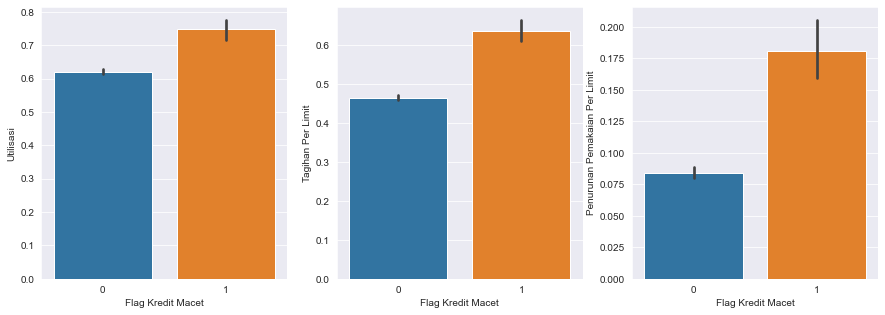

In [50]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

sns.barplot(x = 'flag_kredit_macet', y = 'utilisasi', 
            data = train_df, ax = axes[0]).\
    set(xlabel = 'Flag Kredit Macet', ylabel = 'Utilisasi')

sns.barplot(x = 'flag_kredit_macet', y = 'tagihan_per_limit', 
            data = train_df, ax = axes[1]).\
    set(xlabel = 'Flag Kredit Macet', ylabel = 'Tagihan Per Limit')

sns.barplot(x = 'flag_kredit_macet', y = 'penurunan_pemakaian_per_limit', 
            data = train_df, ax = axes[2]).\
    set(xlabel = 'Flag Kredit Macet', ylabel = 'Penurunan Pemakaian Per Limit')

plt.show()

### **Scaling Setelah Feature Engineering**

**Semua kolom akan discaling sekarang setelah kolom feature engineering dibuat.**

Scaling ini bertujuan agar _performance_ model akan semakin baik setelah ini.

In [51]:
scaler = MinMaxScaler()
scaled_columns = [column for column in train_df if column != 'flag_kredit_macet']

for data in [train_df, test_df]:
    data[scaled_columns] = scaler.fit_transform(data[scaled_columns])
    
display_df(train_df)

,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,...,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan,utilisasi,tagihan_per_limit,penurunan_pemakaian_per_limit
0,0.266667,0.007484,0.003009,0.012049,0.0,0.052108,0.011726,0.01219,0.000000,0.007919,...,0.007036,0.119853,0.120795,0.056080,0.070346,0.113087,0.094515,0.142345,0.123968,0.288495
1,0.066667,0.000171,0.062187,0.000259,0.0,0.052108,0.000000,0.10000,0.000000,0.075677,...,0.000000,0.000000,0.120795,0.045288,0.067090,0.002776,0.000794,0.000300,0.000270,0.286003
2,0.000000,0.001697,0.000000,0.003220,0.0,0.052158,0.000000,0.10000,0.000000,0.082838,...,0.000000,0.000000,0.121751,0.082224,0.065561,0.077183,0.092426,0.064547,0.066971,0.284392
3,0.066667,0.001349,0.046138,0.001747,0.0,0.054687,0.000000,0.09907,0.000000,0.030020,...,0.000000,0.000000,0.123820,0.043441,0.085965,0.001650,0.026245,0.003142,0.002232,0.299054
4,0.133333,0.052980,0.031093,0.102894,0.0,0.052108,0.092669,0.00000,0.119105,0.037869,...,0.092669,0.167147,0.120795,0.162844,0.067238,0.148276,0.114706,0.177838,0.186180,0.286116


(15077, 23)

## **Modelling**

**Melakukan train-test split untuk persiapan modelling.**

Kesuksesan train-test split dicek menggunakan `assert`.

In [52]:
X = train_df.drop('flag_kredit_macet', axis = 1)
y = train_df['flag_kredit_macet'] 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 9, stratify = y)

assert len(X_train) == len(y_train)
assert len(X_valid) == len(y_valid)

### **Model Upgrade**

**Membuat model logistic pertama tanpa hyperparameter tuning.**

Sekaligus prediksi agar pengecekan selanjutnya lebih mudah.

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)

**Akurasi tinggi, namun recall cukup rendah!**

Akurasi bisa mencapai hingga ~90% dan cukup konsisten antara train dan validation, namun recall hanya 1.2%! Hal ini disebabkan oleh kelas yang tidak balance, sehingga akurasi dapat naik dengan cara menebak lebih banyak nasabah sebagai nasabah non-kredit macet.

In [54]:
print('Train data accuracy: {:.3f}'.format(logreg.score(X_train, y_train)))
print('Validation data accuracy: {:.3f}'.format(logreg.score(X_valid, y_valid)))

Train data accuracy: 0.913
Validation data accuracy: 0.911


In [55]:
print('Recall score: {:.3f}'.format(recall_score(y_valid, y_pred)))

Recall score: 0.012


### **Model Kedua**

**Borderline SMOTE dan undersampling dikombinasikan untuk mengatasi kelas yang imbalance.**

Keduanya digabungkan karena terlalu banyak oversampling atau terlalu banyak undersampling akan menyebabkan masalah karena terlalu banyak data berulang atau justru hilangnya informasi penting. Varian borderline SMOTE akan memberikan emphasis lebih pada sample yang sering dimisklasifikasikan, dan parameter telah dipilih untuk optimisasi recall dalam batas yang wajar.

In [56]:
smote = BorderlineSMOTE(sampling_strategy = 0.8, random_state = 9)
under_sampler = RandomUnderSampler(sampling_strategy = 0.8)

X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

**Model dibangun ulang, tetap menggunakan logistic regression.**

In [57]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)

**Akurasi berkurang, namun recall naik drastis.**

Akurasi kini hanya sekitar ~70%, namun recall telah berubah menjadi ~70% juga. Karena bank ini sebenarnya lebih memprioritaskan agar tidak _false negative_, ini adalah trade-off yang sangat baik.

In [58]:
print('Train data accuracy: {:.3f}'.format(logreg.score(X_train, y_train)))
print('Validation data accuracy: {:.3f}'.format(logreg.score(X_valid, y_valid)))

Train data accuracy: 0.775
Validation data accuracy: 0.714


In [59]:
print('Recall score: {:.3f}'.format(recall_score(y_valid, y_pred)))

Recall score: 0.714


## **Evaluation**

**Cross-validation dilakukan dengan function custom, dan hasilnya bagus!**

Kurang lebih tidak beda jauh dengan angka yang telah didapatkan sebelumnya, namun precision ditemukan cukup baik juga sekitar ~70%. Cek definisi function di awal notebook (function menggunakan `cross_validate`).

In [60]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 9)

logreg = LogisticRegression(random_state = 9)

_ = batch_cross_val(logreg, X_train, y_train, kfold)

Mean accuracy: 0.774
Mean precision: 0.704
Mean recall: 0.851
Mean F1-score: 0.770


**Grid-search cross-validation akan dilakukan untuk hyperparameter tuning.**

Untuk optimisasi lebih lanjut, beberapa parameter akan dicoba dan dicari mana yang paling baik. Sebelumnya, logistic regression diset dengan parameter n_jobs = -1 agar bisa menggunakan semua CPU, karena kita perlu segala bantuan yang kita punya untuk grid-search.

In [61]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', None]}

logreg = LogisticRegression(random_state = 9, n_jobs = -1)

# Perlu catch warnings karena beberapa kombinasi tidak akan konvergensi
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    logreg_cv = GridSearchCV(logreg, param_grid, cv = kfold, 
                             scoring = 'recall', n_jobs = -1)

    logreg_cv.fit(X_train, y_train)

In [62]:
print('Parameter terbaik: {}'.format(logreg_cv.best_params_))
print('Skor cross-validation terbaik: {:.3}'.format(logreg_cv.best_score_))

Parameter terbaik: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
Skor cross-validation terbaik: 0.906


**Model final akan dibangun ulang dengan parameter baru, lalu dicek cross-validation score lengkapnya.**

Cross-validation dilakukan dengan `batch_cross_val` seperti sebelumnya, cek di bagian awal notebook untuk melihat definisi functionnya.

**Ditemukan peningkatan recall dan f1-score, dan sedikit penurunan precision.**

Accuracy masih relatif sama, sementara memang kita lebih berfokus pada recall sesuai dengan tujuan bank sebelumnya yang ingin menghindari _false negative_.

In [63]:
logreg_final = LogisticRegression(C = 1, penalty = 'l2', 
                                  class_weight = 'balanced', random_state = 9)

_ = batch_cross_val(logreg_final, X_train, y_train, kfold)

Mean accuracy: 0.762
Mean precision: 0.673
Mean recall: 0.906
Mean F1-score: 0.772


**Pengecekan dengan data validasi menunjukkan recall score sekitar ~80%.**

Terdapat penurunan, namun masih cukup acceptable secara skor. Mengapa terjadi penurunan? Sebenarnya ini adalah efek samping/trade-off dari menggunakan oversampling (salah satunya SMOTE), karena semakin banyak oversampling bisa berpengaruh ke overfitting, tinggal bagaimana kita mengaturnya agar trade-offnya sesuai dan tetap dapat meningkatkan data kita :)

In [64]:
logreg_final.fit(X_train, y_train)
y_pred_valid = logreg_final.predict(X_valid)

print('Validation data accuracy: {:.3f}'.format(logreg_final.score(X_valid, y_valid)))
print('Validation recall score: {:.3f}'.format(recall_score(y_valid, y_pred_valid)))

Validation data accuracy: 0.655
Validation recall score: 0.796


## **Predict New Data**

**Data test sudah siap dari awal, sehingga cukup melakukan predict pada data test.**

In [65]:
y_pred_test = logreg_final.predict(test_df)

**Sekitar 2% dari nasabah pada data test diprediksi akan memiliki kredit macet.**

Sementara 98% sisanya diprediksi tidak akan memiliki kredit macet. Angkanya cukup imbalanced seperti data train, meskipun mungkin relatif lebih parah. Tetapi, memang nasabah kredit macet seharusnya adalah minoritas dibanding keseluruhan nasabah.

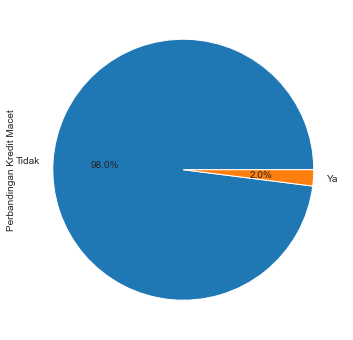

In [66]:
plt.figure(figsize = (6, 6))
pd.Series(y_pred_test).replace({0: 'Tidak', 1: 'Ya'}).\
    value_counts().plot.pie(autopct = '%1.1f%%')

plt.ylabel('Perbandingan Kredit Macet')

plt.show()

## **Kesimpulan/Saran**

**Kesimpulan:**
- Data memiliki imbalanced classification, di mana hanya ada sekitar 10% nasabah dengan kredit macet sehingga menjadi tantangan dalam pembuatan model.
- Nasabah kredit macet memiliki pattern behaviour yang menarik, di mana umumnya mereka memiliki sisa tagihan tidak terbayar besar sekarang, rasio pembayaran yang terus menurun, serta total pemakaian yang pelan-pelan menurun bersama dengan naiknya tagihan, tetapi tidak ada pola secara skor delikuensi, jumlah kartu, ataupun _tenure_.
- Masing-masing kolom memiliki korelasi yang relatif kecil dengan variabel target (maksimum hanya 0.2, dan banyak yang jauh lebih kecil daripada itu).
- Secara accuracy, model memiliki akurasi yang sedang-sedang, sekitar 65-75%, namun secara recall yang memang kita optimize, nilai metriknya cukup baik sekitar ~80%.

**Saran:**
- Bank perlu berhati-hati karena faktor-faktor yang biasanya digunakan untuk menilai pengajuan kredit, seperti skor delikuensi dan _tenure_ yang umumnya dilihat sebagai faktor historis, nyaris tidak berdampak dalam kasus ini.
- Nasabah kredit macet dapat diprediksi dan diantisipasi dari behaviournya, sehingga bank dapat melakukan monitoring kepada behaviour nasabah, menggunakan model ini atau teknik lain, untuk mengantisipasi nasabah yang potensial kredit macet dan mengarahkan mereka kembali ke jalan yang benar jika bisa.
- Data dapat diperlengkapi dengan data demografis, data kredit nasabah yang lain selain kartu kredit, aspek 5C lainnya dari nasabah tersebut, di mana setidaknya data demografis pasti dimiliki oleh bank.
- Jika bisa didapatkan data yang lebih lengkap seperti di atas, model bisa dibangun ulang dan ditingkatkan lagi, atau bisa juga crosscheck untuk mengecek misalnya mengapa nasabah kredit macet kerap kali menurun secara rasio pembayaran (apakah _willingly_ atau _unwillingly_).